## ETH-USDC

In [1]:
# data load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df_cex = pd.read_csv("ETH_USDC_1m_from_01-05-2024.csv")
df_dex = pd.read_csv("ETH_USDC_1m_ohlc.csv")

In [2]:
# merge cex and dex data
cex_dex = df_cex.merge(df_dex, on = "timestamp", how = "inner", suffixes=("_cex", "_dex"))

In [3]:
# take a look at what we've got
cex_dex.head()

,timestamp,open_cex,high_cex,low_cex,close_cex,volume_cex,pair,open_dex,high_dex,low_dex,close_dex,volume_dex
0,2024-05-01 00:00:00,3011.40,3014.60,3011.00,3014.60,5.3843,ETH/USDC,3011.413988,3012.624232,3011.412118,3012.624232,29.363199
1,2024-05-01 00:01:00,3013.59,3015.80,3013.57,3015.05,2.0334,ETH/USDC,3012.624232,3015.436164,3012.624232,3013.945013,81.967318
2,2024-05-01 00:02:00,3014.66,3014.66,3009.54,3010.53,8.8738,ETH/USDC,3013.945013,3014.184071,3011.223938,3011.223938,101.892866
3,2024-05-01 00:03:00,3010.18,3011.60,3010.18,3011.60,0.9529,ETH/USDC,3011.223938,3011.230776,3011.223938,3011.230776,0.165464
4,2024-05-01 00:04:00,3011.59,3012.40,3010.70,3011.20,1.9819,ETH/USDC,3011.230776,3011.280865,3011.230776,3011.276003,1.350767


In [4]:
# function to calculate some variables
def stat_calc(df: pd.DataFrame):
    df = df.copy()
    # absolute difference
    df["abs_diff"] = df["close_cex"] - df["close_dex"]
    # relative difference to minimal price (on cex or dex)
    df["rel_diff"] = (abs(df["abs_diff"]) / df[["close_dex", "close_cex"]].min(axis=1))
    # buy where price is lower
    df["buy"] = np.where(df["abs_diff"] > 0, "DEX", "CEX")
    # sell where price is higher
    df["sell"] = np.where(df["abs_diff"] <= 0, "DEX", "CEX")
    return df
    

In [5]:
# calculate simple variables - apply stat_calc
df_stat = stat_calc(cex_dex)

In [6]:
# fees

# uniswap fee for this pool is 0.05%
dex_pool_fee = 0.0005

# consider 2 different fees for cex: 0.1% is default for spot on binance 
cex_fee_def = 0.001
# minimal fee for binance spot: VIP9 + pay in BNB
cex_fee_min = 0.0001725
# calculate buy and sell prices with fees
df_stat["buy_price_fee_def"] = np.where(df_stat["buy"] == "CEX", df_stat["close_cex"] / (1-cex_fee_def), df_stat["close_dex"] / (1-dex_pool_fee))
df_stat["sell_price_fee_def"] = np.where(df_stat["sell"] == "CEX", df_stat["close_cex"]*(1-cex_fee_def), df_stat["close_dex"] * (1-dex_pool_fee))
# min fee
df_stat["buy_price_fee_min"] = np.where(df_stat["buy"] == "CEX", df_stat["close_cex"] / (1-cex_fee_min), df_stat["close_dex"] / (1-dex_pool_fee))
df_stat["sell_price_fee_min"] = np.where(df_stat["sell"] == "CEX", df_stat["close_cex"]*(1-cex_fee_min), df_stat["close_dex"] * (1-dex_pool_fee))


In [7]:
# calculation of spreads
df_stat["price_spread_fee_def"] = (df_stat["sell_price_fee_def"] - df_stat["buy_price_fee_def"]) / df_stat["buy_price_fee_def"]
df_stat["price_spread_fee_min"] = (df_stat["sell_price_fee_min"] - df_stat["buy_price_fee_min"]) / df_stat["buy_price_fee_min"]


In [8]:
# it's possible to consider different strategies depending on value of spread threshold: the higher it is - the less signals you get

# in the further code we will get statistics for several thresholds

# here we will make calculations with a threshold 0 with a purpose of visualization
# define threshold
spread_threshold = 0
# create signal variable: 1 if spread is larger than threshold
df_stat["signal_fee_def"] = np.where(df_stat["price_spread_fee_def"] > spread_threshold, 1, 0)
df_stat["signal_fee_min"] = np.where(df_stat["price_spread_fee_min"] > spread_threshold, 1, 0)

print(f"Total number of signals with threshold = {spread_threshold} and default CEX fee = {cex_fee_def}: {df_stat["signal_fee_def"].sum()}")
print(f"Total number of signals with threshold = {spread_threshold} and minimal CEX fee = {cex_fee_min}: {df_stat["signal_fee_min"].sum()}")

# shift signal variable to compare it with itself: if values are different - new sequence starts
df_stat["sequence_id_fee_def"] = (df_stat["signal_fee_def"] != df_stat["signal_fee_def"].shift()).cumsum()
# choose sequences with signal presence (1)
groups_with_signal_fee_def = df_stat[df_stat['signal_fee_def'] == 1].groupby("sequence_id_fee_def").size()
# average window size
average_signal_duration_fee_def = groups_with_signal_fee_def.mean()

# same for minimal fee
df_stat["sequence_id_fee_min"] = (df_stat["signal_fee_min"] != df_stat["signal_fee_min"].shift()).cumsum()
# choose sequences with signal presence (1)
groups_with_signal_fee_min = df_stat[df_stat['signal_fee_min'] == 1].groupby("sequence_id_fee_min").size()
# average window size
average_signal_duration_fee_min = groups_with_signal_fee_min.mean()

Total number of signals with threshold = 0 and default CEX fee = 0.001: 3097
Total number of signals with threshold = 0 and minimal CEX fee = 0.0001725: 43126


In [9]:
# longest window
# pretty large spreads
longest_window_index = groups_with_signal_fee_def.idxmax()
df_stat[df_stat["sequence_id_fee_def"] == longest_window_index]

,timestamp,open_cex,high_cex,low_cex,close_cex,volume_cex,pair,open_dex,high_dex,low_dex,...,buy_price_fee_def,sell_price_fee_def,buy_price_fee_min,sell_price_fee_min,price_spread_fee_def,price_spread_fee_min,signal_fee_def,signal_fee_min,sequence_id_fee_def,sequence_id_fee_min
138310,2024-08-05 01:10:00,2334.00,2340.40,2105.00,2107.91,1453.1153,ETH/USDC,2329.366482,2386.249685,2121.858989,...,2110.020020,2143.728497,2108.273677,2143.728497,0.015975,0.016817,1,1,850,15238
138311,2024-08-05 01:11:00,2107.91,2204.80,2105.38,2183.23,1972.6823,ETH/USDC,2144.800898,2199.820907,2092.158116,...,2095.233604,2181.046770,2095.233604,2182.853393,0.040956,0.041819,1,1,850,15238
138312,2024-08-05 01:12:00,2183.23,2268.40,2119.40,2263.62,1872.4331,ETH/USDC,2094.185987,2162.620984,2094.185987,...,2153.702814,2261.356380,2153.702814,2263.229526,0.049985,0.050855,1,1,850,15238
138313,2024-08-05 01:13:00,2268.46,2271.00,2193.27,2256.60,600.8315,ETH/USDC,2152.625962,2160.946310,2126.651427,...,2146.195401,2254.343400,2146.195401,2256.210736,0.050391,0.051261,1,1,850,15238
138314,2024-08-05 01:14:00,2256.80,2318.07,2251.00,2313.67,376.0276,ETH/USDC,2145.122304,2152.029733,2123.423557,...,2128.828531,2311.356330,2128.828531,2313.270892,0.085741,0.086640,1,1,850,15238
138315,2024-08-05 01:15:00,2313.01,2362.87,2301.80,2334.00,434.9029,ETH/USDC,2127.764116,2297.358894,2127.531091,...,2220.354641,2331.666000,2220.354641,2333.597385,0.050132,0.051002,1,1,850,15238
138316,2024-08-05 01:16:00,2334.60,2350.00,2286.67,2289.61,534.6534,ETH/USDC,2219.244464,2279.409489,2187.814046,...,2211.490977,2287.320390,2211.490977,2289.215042,0.034289,0.035146,1,1,850,15238
138317,2024-08-05 01:17:00,2290.21,2335.75,2279.20,2334.20,341.5014,ETH/USDC,2210.385231,2267.942325,2210.385231,...,2220.791755,2331.865800,2220.791755,2333.797350,0.050016,0.050885,1,1,850,15238
138318,2024-08-05 01:18:00,2334.20,2379.20,2332.07,2373.80,370.0463,ETH/USDC,2219.681360,2291.767742,2217.537723,...,2260.348766,2371.426200,2260.348766,2373.390520,0.049142,0.050011,1,1,850,15238
138319,2024-08-05 01:19:00,2374.80,2380.00,2333.09,2336.60,286.7151,ETH/USDC,2259.218591,2259.218591,2222.944436,...,2230.412062,2334.263400,2230.412062,2336.196936,0.046562,0.047428,1,1,850,15238


In [10]:
# longest window for min fee
# almost same window 
longest_window_index = groups_with_signal_fee_min.idxmax()
df_stat[df_stat["sequence_id_fee_min"] == longest_window_index]

,timestamp,open_cex,high_cex,low_cex,close_cex,volume_cex,pair,open_dex,high_dex,low_dex,...,buy_price_fee_def,sell_price_fee_def,buy_price_fee_min,sell_price_fee_min,price_spread_fee_def,price_spread_fee_min,signal_fee_def,signal_fee_min,sequence_id_fee_def,sequence_id_fee_min
138310,2024-08-05 01:10:00,2334.00,2340.40,2105.00,2107.91,1453.1153,ETH/USDC,2329.366482,2386.249685,2121.858989,...,2110.020020,2143.728497,2108.273677,2143.728497,0.015975,0.016817,1,1,850,15238
138311,2024-08-05 01:11:00,2107.91,2204.80,2105.38,2183.23,1972.6823,ETH/USDC,2144.800898,2199.820907,2092.158116,...,2095.233604,2181.046770,2095.233604,2182.853393,0.040956,0.041819,1,1,850,15238
138312,2024-08-05 01:12:00,2183.23,2268.40,2119.40,2263.62,1872.4331,ETH/USDC,2094.185987,2162.620984,2094.185987,...,2153.702814,2261.356380,2153.702814,2263.229526,0.049985,0.050855,1,1,850,15238
138313,2024-08-05 01:13:00,2268.46,2271.00,2193.27,2256.60,600.8315,ETH/USDC,2152.625962,2160.946310,2126.651427,...,2146.195401,2254.343400,2146.195401,2256.210736,0.050391,0.051261,1,1,850,15238
138314,2024-08-05 01:14:00,2256.80,2318.07,2251.00,2313.67,376.0276,ETH/USDC,2145.122304,2152.029733,2123.423557,...,2128.828531,2311.356330,2128.828531,2313.270892,0.085741,0.086640,1,1,850,15238
138315,2024-08-05 01:15:00,2313.01,2362.87,2301.80,2334.00,434.9029,ETH/USDC,2127.764116,2297.358894,2127.531091,...,2220.354641,2331.666000,2220.354641,2333.597385,0.050132,0.051002,1,1,850,15238
138316,2024-08-05 01:16:00,2334.60,2350.00,2286.67,2289.61,534.6534,ETH/USDC,2219.244464,2279.409489,2187.814046,...,2211.490977,2287.320390,2211.490977,2289.215042,0.034289,0.035146,1,1,850,15238
138317,2024-08-05 01:17:00,2290.21,2335.75,2279.20,2334.20,341.5014,ETH/USDC,2210.385231,2267.942325,2210.385231,...,2220.791755,2331.865800,2220.791755,2333.797350,0.050016,0.050885,1,1,850,15238
138318,2024-08-05 01:18:00,2334.20,2379.20,2332.07,2373.80,370.0463,ETH/USDC,2219.681360,2291.767742,2217.537723,...,2260.348766,2371.426200,2260.348766,2373.390520,0.049142,0.050011,1,1,850,15238
138319,2024-08-05 01:19:00,2374.80,2380.00,2333.09,2336.60,286.7151,ETH/USDC,2259.218591,2259.218591,2222.944436,...,2230.412062,2334.263400,2230.412062,2336.196936,0.046562,0.047428,1,1,850,15238


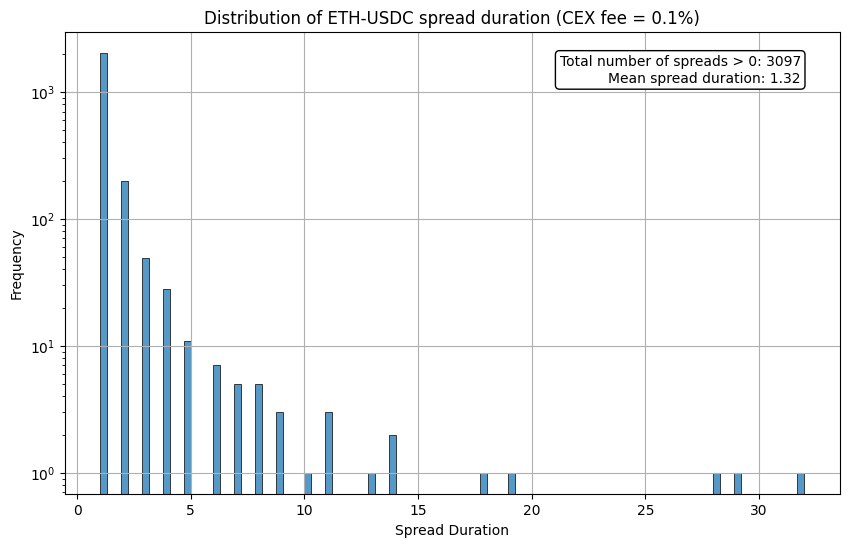

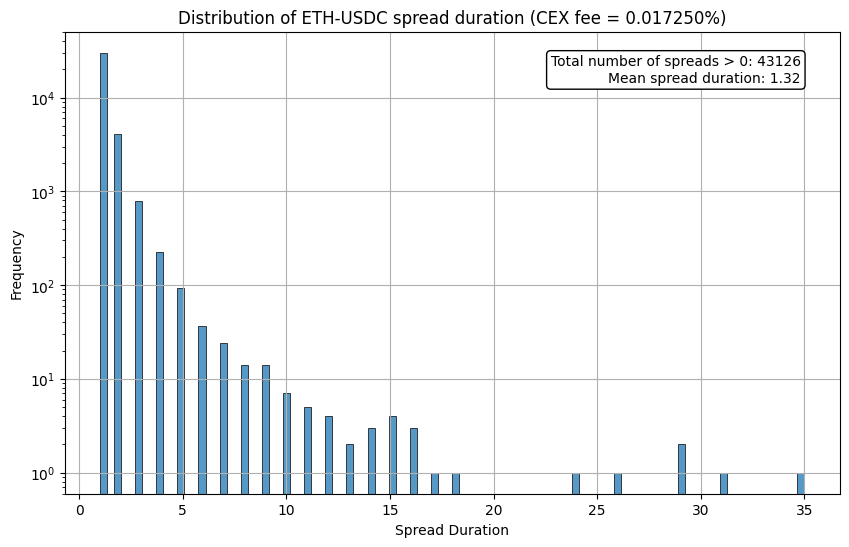

In [11]:
# plot distribution of windows' length of positive spreads

# def cex fee
filtered = df_stat[(df_stat['price_spread_fee_def'] > 0)]
count = len(filtered)
mean_val = filtered['price_spread_fee_def'].mean()

plt.figure(figsize=(10, 6))
sns.histplot(groups_with_signal_fee_def , bins=100, kde=False)
plt.yscale('log')
plt.title('Distribution of ETH-USDC spread duration (CEX fee = 0.1%)')
plt.xlabel('Spread Duration')
plt.ylabel('Frequency')
plt.grid(True)
plt.text(
    0.95, 0.95,
    f'Total number of spreads > 0: {count}\nMean spread duration: {average_signal_duration_fee_def:.2f}',
    horizontalalignment='right',
    verticalalignment='top',
    transform=plt.gca().transAxes,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="black")
)
plt.show()

# min cex fee
filtered = df_stat[(df_stat['price_spread_fee_min'] > 0)]
count = len(filtered)
mean_val = filtered['price_spread_fee_min'].mean()
plt.figure(figsize=(10, 6))
sns.histplot(groups_with_signal_fee_min, bins=100, kde=False)
plt.yscale('log')
plt.title('Distribution of ETH-USDC spread duration (CEX fee = 0.017250%)')
plt.xlabel('Spread Duration')
plt.ylabel('Frequency')
plt.grid(True)

plt.text(
    0.95, 0.95,
    f'Total number of spreads > 0: {count}\nMean spread duration: {average_signal_duration_fee_def:.2f}',
    horizontalalignment='right',
    verticalalignment='top',
    transform=plt.gca().transAxes,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="black")
)

plt.show()

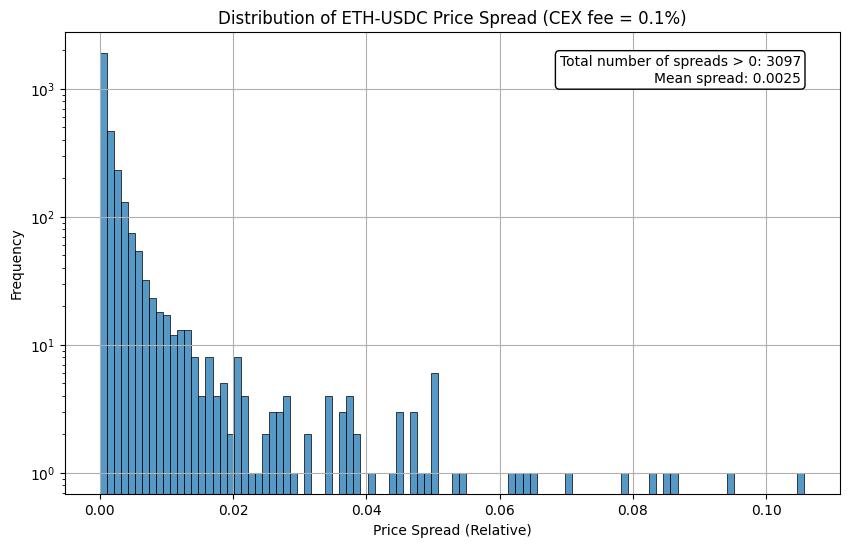

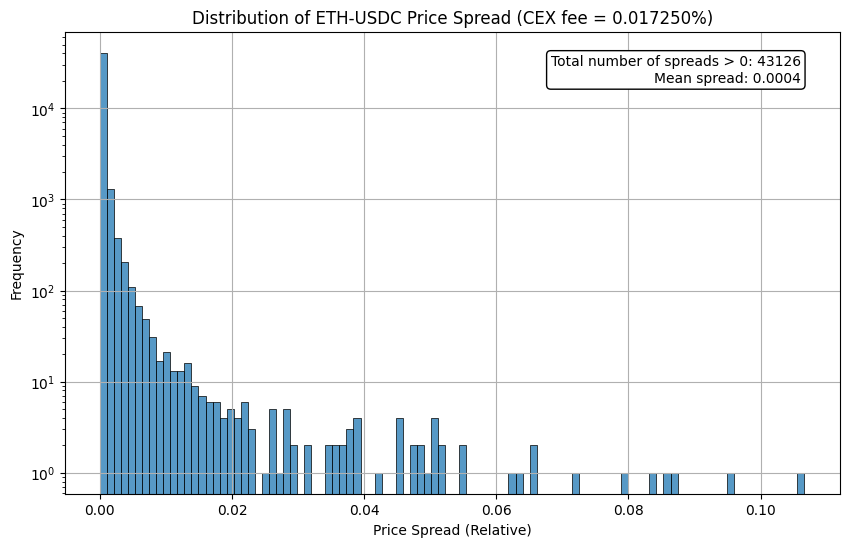

In [12]:
# plot distribution of positive spreads
# consider only spreads larger than 0

# def cex fee
filtered = df_stat[(df_stat['price_spread_fee_def'] > 0)]
count = len(filtered)
mean_val = filtered['price_spread_fee_def'].mean()
plt.figure(figsize=(10, 6))
sns.histplot(filtered['price_spread_fee_def'] , bins=100, kde=False)
plt.yscale('log')
plt.title('Distribution of ETH-USDC Price Spread (CEX fee = 0.1%)')
plt.xlabel('Price Spread (Relative)')
plt.ylabel('Frequency')
plt.grid(True)
plt.text(
    0.95, 0.95,
    f'Total number of spreads > 0: {count}\nMean spread: {mean_val:.4f}',
    horizontalalignment='right',
    verticalalignment='top',
    transform=plt.gca().transAxes,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="black")
)
plt.show()

# min cex fee
filtered = df_stat[(df_stat['price_spread_fee_min'] > 0)]
count = len(filtered)
mean_val = filtered['price_spread_fee_min'].mean()
plt.figure(figsize=(10, 6))
sns.histplot(filtered['price_spread_fee_min'] , bins=100, kde=False)
plt.yscale('log')
plt.title('Distribution of ETH-USDC Price Spread (CEX fee = 0.017250%)')
plt.xlabel('Price Spread (Relative)')
plt.ylabel('Frequency')
plt.grid(True)

plt.text(
    0.95, 0.95,
    f'Total number of spreads > 0: {count}\nMean spread: {mean_val:.4f}',
    horizontalalignment='right',
    verticalalignment='top',
    transform=plt.gca().transAxes,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="black")
)

plt.show()

In [13]:
# define thresholds
spread_thresholds = [0, 0.005, 0.01]

def signal(thresholds : list):
    results = {}
    # iterate over thresholds
    for spread_threshold in thresholds:
    # create signal variable: 1 if spread is larger than threshold
        signal_fee_def = np.where(df_stat["price_spread_fee_def"] > spread_threshold, 1, 0)
        signal_fee_min = np.where(df_stat["price_spread_fee_min"] > spread_threshold, 1, 0)
        results["threshold_" + str(spread_threshold)] = (signal_fee_def.sum(), signal_fee_min.sum())
    # display results
        print("---------------------------------------------------------------------------------------------------")
        print(f"Total number of signals with threshold = {spread_threshold} and default CEX fee = {cex_fee_def}: {signal_fee_def.sum()}")
        print(f"Total number of signals with threshold = {spread_threshold} and minimal CEX fee = {cex_fee_min}: {signal_fee_min.sum()}")
        print("---------------------------------------------------------------------------------------------------")
    return results
number_of_signals = signal(spread_thresholds)


---------------------------------------------------------------------------------------------------
Total number of signals with threshold = 0 and default CEX fee = 0.001: 3097
Total number of signals with threshold = 0 and minimal CEX fee = 0.0001725: 43126
---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------
Total number of signals with threshold = 0.005 and default CEX fee = 0.001: 301
Total number of signals with threshold = 0.005 and minimal CEX fee = 0.0001725: 363
---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------
Total number of signals with threshold = 0.01 and default CEX fee = 0.001: 147
Total number of signals with threshold = 0.01 and minimal CEX fee = 0.0001725: 162
---------------

In [14]:
# calculation of average spread time length
def avg_spread_window(thresholds):
    results = {}
    for spread_threshold in thresholds:
        # compute signals
        signal_fee_def = np.where(df_stat["price_spread_fee_def"] > spread_threshold, 1, 0)
        signal_fee_min = np.where(df_stat["price_spread_fee_min"] > spread_threshold, 1, 0)

        df_stat["signal_fee_def"] = signal_fee_def
        # shift signal variable to compare it with itself: if values are different - new sequence starts
        df_stat["sequence_id_fee_def"] = (df_stat["signal_fee_def"] != df_stat["signal_fee_def"].shift()).cumsum()
        # choose sequences with signal presence (1)
        groups_with_signal_fee_def = df_stat[df_stat['signal_fee_def'] == 1].groupby("sequence_id_fee_def").size()
        # average window size
        average_signal_duration_fee_def = groups_with_signal_fee_def.mean()

        # same for minimal fee
        df_stat["signal_fee_min"] = signal_fee_min
        df_stat["sequence_id_fee_min"] = (df_stat["signal_fee_min"] != df_stat["signal_fee_min"].shift()).cumsum()
        # choose sequences with signal presence (1)
        groups_with_signal_fee_min = df_stat[df_stat['signal_fee_min'] == 1].groupby("sequence_id_fee_min").size()
        # average window size
        average_signal_duration_fee_min = groups_with_signal_fee_min.mean()

        print("---------------------------------------------------------------------------------------------------")
        print(f"Average duration of a signal (with defaul CEX fee = {cex_fee_def}) is: {average_signal_duration_fee_def:.2f}.")
        print(f"Average duration of a signal (with minimal CEX fee = {cex_fee_min}) is: {average_signal_duration_fee_min:.2f}.")
        print("---------------------------------------------------------------------------------------------------")

        results["threshold_" + str(spread_threshold)] = (average_signal_duration_fee_def, average_signal_duration_fee_min)

    # drop auxilary columns no to mess data
    df_stat.drop(columns = ["signal_fee_def", "sequence_id_fee_def", "signal_fee_min", "sequence_id_fee_min"], axis = 1)
    return results
avg_spread_windows = avg_spread_window(spread_thresholds)

---------------------------------------------------------------------------------------------------
Average duration of a signal (with defaul CEX fee = 0.001) is: 1.32.
Average duration of a signal (with minimal CEX fee = 0.0001725) is: 1.22.
---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------
Average duration of a signal (with defaul CEX fee = 0.001) is: 1.45.
Average duration of a signal (with minimal CEX fee = 0.0001725) is: 1.39.
---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------
Average duration of a signal (with defaul CEX fee = 0.001) is: 1.65.
Average duration of a signal (with minimal CEX fee = 0.0001725) is: 1.57.
-----------------------------------------------------------------------